<img src="http://www.ceic.org.ar/spanish/img/siisa-logo.jpg" align='right'>

## Funciones auxiliares que podrian ser utiles.

In [1]:
def get_data_fsql(query,serverName='MiAdelanto'):
    """Traer data de las bases SQL
    query=String donde hago la query que quiero traer
    serverName= String(siisa/MiAdelanto)"""
    #Select Server 'MiAdelanto'
    if serverName=='MiAdelanto':
        #Name server.
        server='miadelanto.cw8tpboctrtb.us-west-2.rds.amazonaws.com'
        # user server.
        user='jesica'
        # Password.
        password='Jesisol123'
        # used Database.
        db='dtsMiAdelanto'
    #Select Server 'siisa'
    elif serverName=='siisa':
        #Name server.
        server='motorsiisa2.cn5dtopedl5u.us-east-1.rds.amazonaws.com'
        # user server.
        user='elias'
        # Password.
        password='123456'
        # used Database.
        db='sbrde'
    else:
        print("Base de datos seleccionada incorrecta:")
    # connector instance
    conn = pymssql.connect(server=server, user=user, password=password, database=db)
    # Selected Query.
    df = pd.read_sql(query, conn)
    # Close connection.
    conn.close()
    return df

### Base de datos de prestamos 



Con la consulta sql a continuacion me traigo la base de datos de prestamos joineada con los estados para cada prestamo.

In [2]:
import pymssql
import pandas as pd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\elias\Programs\anaconda3\envs\siisa\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  """Entry point for launching an IPython kernel.


#### Consulta sobre la base mi adelanto para traer el dataframe de prestamos.

In [3]:
# Genero la query y luego guardo la query en una dataframe.
#query="""select a.PrestamoId,a.ClienteId,a.PlanId,a.Fecha,a.FechaRetiro,a.NroCuotas,a.EstadoId,a.Capital,a.CreateDate,c.Apellidos,c.Nombres,c.CUIL,c.Actividad,c.Sexo,c.Ingresos,c.DiaCobro,d.EstadoNombre from dtsMiAdelanto.dbo.Prestamos a
#LEFT JOIN  dtsMiAdelanto.dbo.Clientes c ON c.ClienteId=a.ClienteId
#LEFT JOIN dtsMiAdelanto.dbo.PrestamosEstados d ON a.EstadoId= d.EstadoId"""
query="""/* Consulta que debo realizar de modo de traer el dataframe. */
SELECT 
tprestamos.CreateDate,
tprestamos.PrestamoComercioId,
tprestamos.PrestamoId,
tprestamos.ClienteId,
tprestamos.PlanId,
tprestamos.Fecha,
tprestamos.FechaRetiro,
tprestamos.NroCuotas,
tprestamos.Capital,
tprestamos.Anticipo,
tclientes.Apellidos,
tclientes.Nombres,
tclientes.CUIL,
tclientes.Sexo,
tclientes.FechaNacimiento,
tclientes.Actividad,
tclientes.NacionalidadId,
tclientes.DiaCobro,
tclientes.CBU,
tbancos.BancoId,
tbancos.BancoNombre,
tprestamoestado.EstadoNombre,
pedidosMotorclean.idTrans,
pedidosMotorclean.Dictamen
/* tabla principal */
from dtsMiAdelanto.dbo.Prestamos           as tprestamos
/* joineo con la tabla de clientes. */
LEFT JOIN dtsMiAdelanto.dbo.Clientes       as tclientes      ON tprestamos.ClienteId=tclientes.ClienteId
/* joineo con la tabla de bancos. */
LEFT JOIN dtsMiAdelanto.dbo.bancos as tbancos  ON tbancos.BancoId=    SUBSTRING(tclientes.CBU,1,3)
/* joineo con la tabla de prestamos Estados. */
LEFT JOIN dtsMiAdelanto.dbo.PrestamosEstados as tprestamoestado   ON tprestamoestado.EstadoId=tprestamos.EstadoId
/* joineo con la tabla de pedidosMotor. */
LEFT JOIN 
    (select *
from
 (
  select *
     ,row_number() 
      over (partition by convert(varchar, Fecha, 23), clienteId
            order by clienteId desc) as rn 
  from dtsMiAdelanto.dbo.ClientesPedidosMotor
 ) as dt
where rn = 1 and Dictamen!='Rechazar' and Dictamen!='Error' and clienteId!=0) AS pedidosMotorclean
ON pedidosMotorclean.clienteId=tprestamos.ClienteId   and (pedidosMotorclean.Fecha BETWEEN DATEADD(minute,-1,tprestamos.CreateDate) AND DATEADD(MINUTE,1,tprestamos.CreateDate)) 
 """

# Make dataframe from query.
df_prestamos = get_data_fsql(query)

#### Consulta sobre la base siisa motor para traer el dataframe de variables.

In [4]:
# Ids que no son vacios del dataframe de prestamos.
ids2get=df_prestamos[~df_prestamos.idTrans.isna()]['idTrans'].astype('int64')

In [5]:
# Me traigo todo el dump de variables para una lista de executonsId del dataframe de prestamos.
query = "{} IN ({})".format("""select a.*,b.clientId,b.policyId,b.executionDate from dbo.RulePolicyExecutionDumps a
LEFT JOIN dbo.RulePolicyExecutions b ON a.executionId=b.executionId
WHERE  a.executionId  """, ", ".join([str(n) for n in ids2get.values]))
# Make dataframe from query.
df_vars_siisa_engine = get_data_fsql(query,serverName='siisa')

In [6]:
# pivoteo la tabla y reformateo variables
df_vars_siisa=df_vars_siisa_engine[['executionId','varName','varValue','executionDate']].pivot(index='executionId',columns='varName', values='varValue')
df_vars_siisa['cuil']=df_vars_siisa.cuil.astype('float').astype('int64')

In [7]:
# joineo las tablas de prestamos y la de variables de siisa.
df_merge=pd.merge(left=df_prestamos,right=df_vars_siisa, how='left', left_on='idTrans', right_on='executionId').dropna(how='all', axis=1)


### Distribucion de casos en la base de datos de prestamos.

In [8]:
df_merge.EstadoNombre.value_counts()

Cancelado                    967
En Abogado                   441
Transferencia Pendiente      418
Vigente                      144
Refinanciado                  56
Incobrable Fraude              8
Incobrable Fallecido           3
Refinanciación Vigente         2
En Abogado (Refinanciado)      1
Name: EstadoNombre, dtype: int64

In [9]:
df_merge.EstadoNombre.value_counts().sum()

2040

In [10]:
# Selecciono prestamos que esten con status [Cancelado, En Abogado, Vigente]
# Descartando los status [Transferencia Pendiente, Refinanciado, Refinanciacion Vigente, En Abogado(Refinanciado)]
df_prestamos_clean=df_merge[ (df_merge['EstadoNombre'] == 'Cancelado') | (df_merge['EstadoNombre'] == 'En Abogado') | (df_merge['EstadoNombre'] == 'Vigente') ]
print("Los prestamos con status [Cancelado, En Abogado, Vigente] son:",len(df_prestamos_clean))


Los prestamos con status [Cancelado, En Abogado, Vigente] son: 1552


In [11]:
df_prestamos_clean.EstadoNombre.value_counts()

Cancelado     967
En Abogado    441
Vigente       144
Name: EstadoNombre, dtype: int64

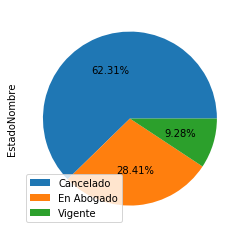

In [12]:
# Distribucion de status de prestamos.
ax=df_prestamos_clean.EstadoNombre.value_counts().plot(kind='pie',autopct='%.2f%%', labels=['','','',''],  fontsize=10)
#df[col].plot(kind='pie', autopct='%.2f', labels=['','','',''],  ax=ax, title=col, fontsize=10)
ax.legend(loc=3, labels=df_prestamos_clean.EstadoNombre.value_counts().index)

clientes relevados sacando las redundancias  (833, 153)


C:\Users\elias\Programs\anaconda3\envs\siisa\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


Sin redundancias (833,)


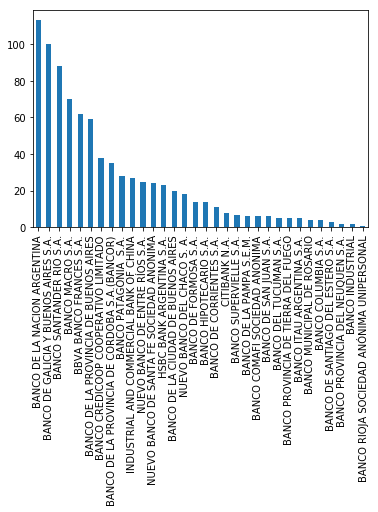

In [13]:
# Distribucion de bancos de los prestamos donde esta relevado.
# Saco la redundancia de clientes.
clientes_sin_redundancia=df_prestamos_clean.drop_duplicates(subset='ClienteId',keep='last')[~df_prestamos_clean.BancoNombre.isna()]
print("clientes relevados sacando las redundancias ",clientes_sin_redundancia.shape)
#
clientes_sin_redundancia[~clientes_sin_redundancia.BancoNombre.isna()]['BancoNombre'].value_counts().plot(kind='bar')
print("Sin redundancias",clientes_sin_redundancia[~clientes_sin_redundancia.BancoNombre.isna()]['BancoNombre'].shape)

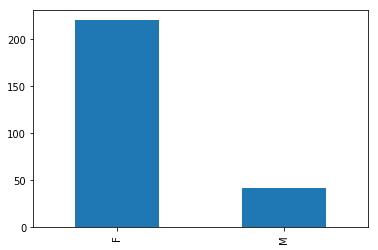

In [14]:
# Distribucion de sexo historico.
clientes_sin_redundancia[~clientes_sin_redundancia.Sexo.isna()]['Sexo'].value_counts().plot(kind='bar')

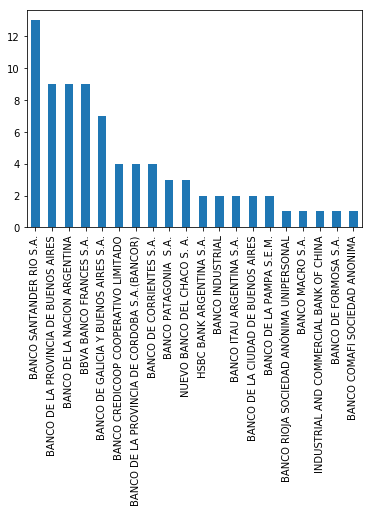

In [15]:
# En status "Vigente"
clientes_sin_redundancia_nonEmpty=clientes_sin_redundancia[~clientes_sin_redundancia.BancoNombre.isna()]
clientes_sin_redundancia_nonEmpty[clientes_sin_redundancia_nonEmpty.EstadoNombre=='Vigente']['BancoNombre'].value_counts().plot(kind='bar')

In [16]:
df_prestamos_clean[df_prestamos_clean.EstadoNombre=='Vigente']['BancoNombre']

5           BANCO DE GALICIA Y BUENOS AIRES S.A.
6           BANCO DE GALICIA Y BUENOS AIRES S.A.
7           BANCO DE GALICIA Y BUENOS AIRES S.A.
36                       BBVA BANCO FRANCES S.A.
72                         BANCO PATAGONIA  S.A.
76                         BANCO PATAGONIA  S.A.
106        BANCO DE LA PROVINCIA DE BUENOS AIRES
109                                         None
144                                         None
159         BANCO CREDICOOP COOPERATIVO LIMITADO
161         BANCO CREDICOOP COOPERATIVO LIMITADO
165                 BANCO DE LA NACION ARGENTINA
170         BANCO DE GALICIA Y BUENOS AIRES S.A.
181                     BANCO SANTANDER RIO S.A.
190                     BANCO SANTANDER RIO S.A.
208                     BANCO SANTANDER RIO S.A.
235                 BANCO DE LA NACION ARGENTINA
243                 BANCO DE LA NACION ARGENTINA
289                     BANCO SANTANDER RIO S.A.
295                     BANCO SANTANDER RIO S.A.
316                 

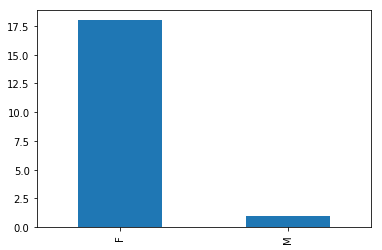

In [17]:
clientes_sin_redundancia_nonEmpty[clientes_sin_redundancia_nonEmpty.EstadoNombre=='Vigente']['Sexo'].value_counts().plot(kind='bar')

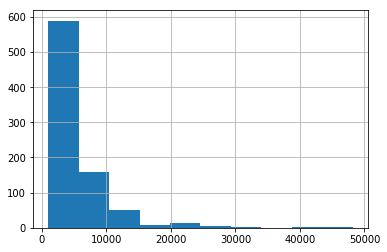

In [18]:
clientes_sin_redundancia_nonEmpty.Capital.hist()

In [19]:
df_prestamos_clean['CUIL']=df_prestamos_clean.CUIL.astype('float').astype('int64')

C:\Users\elias\Programs\anaconda3\envs\siisa\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [20]:
df_prestamos_clean['CreateDate']=pd.to_datetime(df_prestamos_clean.CreateDate)

C:\Users\elias\Programs\anaconda3\envs\siisa\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Consulta sobre la base de datos de cuotas para generar los ids de prestamos donde hubo un retraso en alguna de las cuotas de mas de 90 dias.

In [21]:
# Genero una consulta sobre la base de cuotas.
query = "{} IN ({})".format("""select * from dtsMiAdelanto.dbo.Cuotas
WHERE dtsMiAdelanto.dbo.Cuotas.PrestamoId  """, ", ".join([str(n) for n in df_prestamos_clean.PrestamoId.values]))
# Make dataframe from query.
df_cuotas = get_data_fsql(query)

In [22]:
df_cuotas.head(3)

,PrestamoComercioId,PrestamoSucursalId,PrestamoId,CuotaId,FechaIni,FechaVto,FechaVto2,FechaCobro,EstadoId,Capital,...,NotaCreditoNro,NotaCreditoFecha,attrTransferencia,CreateUser,CreateDate,UpdateUser,UpdateDate,DeleteUser,DeleteDate,attrDeleted
0,1,1,9999,1,2015-12-21,2016-02-08,2016-02-08,NaT,1,4150.00,...,None,None,None,sergiorocha,2016-08-03 14:47:00,None,None,None,NaT,None
1,1,1,100017,1,2016-03-07,2016-04-11,2016-04-11,NaT,1,333.33,...,None,None,None,dts,2016-01-01 00:00:00,None,None,sergiorocha,2016-06-27 13:28:00,True
2,1,1,100017,2,2016-04-11,2016-05-10,2016-05-10,NaT,1,333.33,...,None,None,None,dts,2016-01-01 00:00:00,None,None,sergiorocha,2016-06-27 13:28:00,True


In [23]:
df_cuotas.shape

(4044, 41)

####  Genero una columna de diferencia de dias entre el pago y el vencimiento.

In [24]:
import numpy as np
df_cuotas['diff_days'] = df_cuotas['FechaCobro'] - df_cuotas['FechaVto']
df_cuotas['diff_days']=df_cuotas['diff_days']/np.timedelta64(1,'D')

In [25]:
# Numero de instancias donde se atraso el pago.
df_cuotas.diff_days[df_cuotas.diff_days > 90 ].shape

(240,)

In [26]:
df_cuotas.diff_days[df_cuotas.diff_days < 90 ].shape

(2436,)

In [27]:
#  Encuentro todos los prestamosIDs donde hay un retraso de al menos 90 dias en el pago de alguna de las cuotas.
df_prestamos_atrasados=df_cuotas[ df_cuotas.diff_days > 90 ][['PrestamoId','diff_days']].drop_duplicates(subset='PrestamoId')

In [28]:
# Numero de prestamos unicos donde se presento un retraso en la cuota.
df_prestamos_atrasados.shape

(173, 2)

In [29]:
df_prestamos_atrasados.head()

,PrestamoId,diff_days
25,100028,225.0
33,100031,406.0
65,100047,560.0
73,100052,591.0
76,100053,955.0


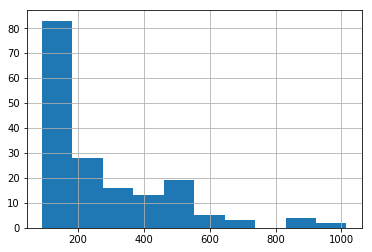

In [30]:
# Imprimo la distribucion de atrasos en el pago de deuda.
df_prestamos_atrasados['diff_days'].hist(bins=10)

### Busco los ids de prestamos que defini arriba como morosos en la base de datos de prestamos y defino una nueva columna que los define como tal.

In [31]:
df_prestamos_modelar=pd.merge(left=df_prestamos_clean,right=df_prestamos_atrasados, how='left', left_on='PrestamoId', right_on='PrestamoId')

In [32]:
df_prestamos_modelar.shape

(1552, 154)

In [33]:
# Defino que todos los usuarios son Nomorsos por defecto.
df_prestamos_modelar['target']='Nomoroso'

In [34]:
# Por definicion los que esta en abogado es porque son morosos.
df_prestamos_modelar.loc[df_prestamos_modelar['EstadoNombre'] == 'En Abogado', 'target'] = 'moroso'

In [35]:
# Los clientes que tienen una deuda mayor a 90 dias los defino como morosos.
df_prestamos_modelar.loc[df_prestamos_modelar['diff_days'] > 90 , 'target'] = 'moroso'

In [36]:
df_prestamos_modelar.target.value_counts()

Nomoroso    1058
moroso       494
Name: target, dtype: int64

In [37]:
df_prestamos_modelar[~df_prestamos_modelar.siisa_cuil.isna()].shape

(226, 155)

#### Elijo las variables que ingreso en el modelo.

In [38]:
for c in df_prestamos_clean.columns:
    print(c)

CreateDate
PrestamoComercioId
PrestamoId
ClienteId
PlanId
Fecha
FechaRetiro
NroCuotas
Capital
Apellidos
Nombres
CUIL
Sexo
FechaNacimiento
Actividad
NacionalidadId
DiaCobro
CBU
BancoId_x
BancoNombre
EstadoNombre
idTrans
Dictamen
BancoId_y
Edad
cantTotalPrestamos
capitalMaximo
cdiasAtrasoAnterior
cuil
cuotasPendientesAnterior
cuotasTotalesAnterior
decisionResult
diasDesdeAnterior
disponible
montoCuota
siisa_Dup1
siisa_Dup2
siisa_Dup3
siisa_Dup4
siisa_DupCuil1
siisa_DupCuil2
siisa_DupCuil3
siisa_DupCuil4
siisa_apellidoNombre
siisa_autonomo
siisa_autonomoMeses
siisa_bacCompromiso
siisa_cacheHit
siisa_cant1s
siisa_cant2s
siisa_cant3s
siisa_cant4s
siisa_cant5s
siisa_cant6s
siisa_cantCheques
siisa_cantMoras
siisa_cantMorasBCRA
siisa_codR
siisa_compromiso
siisa_concursosQuiebras
siisa_consultaError
siisa_consultasAno
siisa_consultasDia
siisa_consultasDosAno
siisa_consultasMes
siisa_consultasSeisMeses
siisa_consultasSemana
siisa_consultasTresMeses
siisa_cuil
siisa_cuitsCheques
siisa_direccion
s

In [39]:
var="""
NroCuotas
Capital
Edad
cuotasPendientesAnterior
disponible
montoCuota
siisa_cant1s
siisa_cantMoras
siisa_cantMorasBCRA
siisa_compromiso
siisa_ingreso
siisa_monto1s
siisa_montoMorasBCRA
siisa_score
siisa_sesCat
sueldo
target
"""
l=[]
for v in var.split():
    l.append(v)

In [40]:
data = df_prestamos_modelar[df_prestamos_modelar.columns.intersection(l)][~df_prestamos_modelar.siisa_cuil.isna()]

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226 entries, 71 to 1551
Data columns (total 17 columns):
NroCuotas                   226 non-null int64
Capital                     226 non-null float64
Edad                        222 non-null object
cuotasPendientesAnterior    225 non-null object
disponible                  226 non-null object
montoCuota                  226 non-null object
siisa_cant1s                226 non-null object
siisa_cantMoras             226 non-null object
siisa_cantMorasBCRA         226 non-null object
siisa_compromiso            226 non-null object
siisa_ingreso               226 non-null object
siisa_monto1s               226 non-null object
siisa_montoMorasBCRA        226 non-null object
siisa_score                 226 non-null object
siisa_sesCat                226 non-null object
sueldo                      226 non-null object
target                      226 non-null object
dtypes: float64(1), int64(1), object(15)
memory usage: 31.8+ KB


In [42]:
data.Edad.fillna(0, inplace = True) 
data.cuotasPendientesAnterior.fillna(0, inplace = True) 

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226 entries, 71 to 1551
Data columns (total 17 columns):
NroCuotas                   226 non-null int64
Capital                     226 non-null float64
Edad                        226 non-null object
cuotasPendientesAnterior    226 non-null object
disponible                  226 non-null object
montoCuota                  226 non-null object
siisa_cant1s                226 non-null object
siisa_cantMoras             226 non-null object
siisa_cantMorasBCRA         226 non-null object
siisa_compromiso            226 non-null object
siisa_ingreso               226 non-null object
siisa_monto1s               226 non-null object
siisa_montoMorasBCRA        226 non-null object
siisa_score                 226 non-null object
siisa_sesCat                226 non-null object
sueldo                      226 non-null object
target                      226 non-null object
dtypes: float64(1), int64(1), object(15)
memory usage: 31.8+ KB


In [44]:
# hago dummies para el numero de cuotas.
Ncuotas=pd.get_dummies(data['NroCuotas'],prefix='NroCuotas')
# hago dummies la sesCat.
sesCat=pd.get_dummies(data['siisa_sesCat'],prefix='sesCat') 
# Concateno toda la info.
modelar = pd.concat([data,Ncuotas,sesCat],axis=1)
#
modelar.drop('target', axis=1, inplace=True)
#
modelar.drop('NroCuotas', axis=1, inplace=True)
#
modelar.drop('siisa_sesCat', axis=1, inplace=True)
#


In [45]:
modelar.head()

,Capital,Edad,cuotasPendientesAnterior,disponible,montoCuota,siisa_cant1s,siisa_cantMoras,siisa_cantMorasBCRA,siisa_compromiso,siisa_ingreso,...,sueldo,NroCuotas_1,NroCuotas_2,NroCuotas_3,NroCuotas_4,sesCat_1,sesCat_2,sesCat_3,sesCat_4,sesCat_5
71,7500.0,42,0,6384,0,1,0,0,6000,100000,...,0,0,0,1,0,0,1,0,0,0
102,5000.0,27,0,6384,0,1,0,0,1888.88888888889,25000,...,0,0,0,1,0,0,0,1,0,0
126,3000.0,31,0,6384,0,5,0,0,10200,20000,...,8,0,0,0,1,0,0,0,1,0
149,4000.0,25,0,6384,0,2,0,0,10500,20000,...,12600,0,0,1,0,0,0,0,1,0
158,3000.0,0,0,5409.44444444444,3559,1,0,0,1630.55555555556,30000,...,16000,1,0,0,0,0,1,0,0,0


In [46]:
modelar.columns

Index(['Capital', 'Edad', 'cuotasPendientesAnterior', 'disponible',
       'montoCuota', 'siisa_cant1s', 'siisa_cantMoras', 'siisa_cantMorasBCRA',
       'siisa_compromiso', 'siisa_ingreso', 'siisa_monto1s',
       'siisa_montoMorasBCRA', 'siisa_score', 'sueldo', 'NroCuotas_1',
       'NroCuotas_2', 'NroCuotas_3', 'NroCuotas_4', 'sesCat_1', 'sesCat_2',
       'sesCat_3', 'sesCat_4', 'sesCat_5'],
      dtype='object')

In [47]:
# Encodear las etiquetas usando LabelEncoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(data['target'])

In [48]:
y.shape

(226,)

In [49]:
le.classes_

array(['Nomoroso', 'moroso'], dtype=object)

In [50]:
modelar.shape

(226, 23)

In [51]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

SEED = 1
treeclf = DecisionTreeClassifier(random_state=SEED)

# Import GridSearchCV
from sklearn.model_selection import GridSearchCV
# Define the grid of hyperparameters 'params_dt'
params_dt = {
    'max_depth': list(range(3, 50)),
    'min_samples_leaf': [0.04, 0.06, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5],
    'max_features': [0.2, 0.4, 0.6, 0.8]
    }
# Instantiate a 10-fold CV grid search object 'grid_dt'
grid_search = GridSearchCV(estimator=treeclf,param_grid=params_dt,scoring='recall_weighted',cv=5,n_jobs=-1)
# Fit 'grid_dt' to the training data
grid_search.fit(modelar, y)

# Extract best hyperparameters from 'grid_dt'
best_hyperparams = grid_search.best_params_
print('Best hyperparameters:\n', best_hyperparams)
# Extract best CV score from 'grid_dt'
best_CV_score = grid_search.best_score_
print('Best CV accuracy'.format(best_CV_score))

Best hyperparameters:
 {'max_depth': 3, 'max_features': 0.2, 'min_samples_leaf': 0.2}
Best CV accuracy


C:\Users\elias\Programs\anaconda3\envs\siisa\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [52]:
from sklearn.metrics import SCORERS

SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [53]:
best_tree=grid_search.best_estimator_
best_tree.fit(modelar, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=0.2, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

In [54]:
tree_preds = best_tree.predict_proba(modelar)[:, 1]
tree_performance = roc_auc_score(y, tree_preds)

print( 'DecisionTree: Area under the ROC curve = {}'.format(tree_performance))

DecisionTree: Area under the ROC curve = 0.7895057342941236


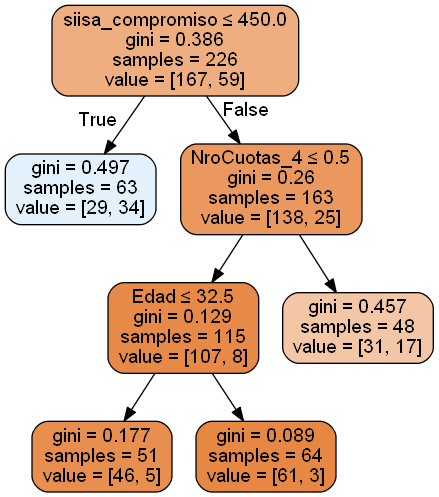

In [55]:
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
atributos = modelar.columns
# Visualizar el árbol usando graphviz
dot_data = export_graphviz(best_tree, out_file=None,  
                feature_names=atributos,  
                filled=True, rounded=True,  
                special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [56]:
le.classes_

array(['Nomoroso', 'moroso'], dtype=object)

In [57]:
# Calcular la importancia de los atributos
pd.DataFrame({'Atributo':atributos,
              'importancia':best_tree.feature_importances_}).sort_values('importancia',
                                                                      ascending=False).head()

,Atributo,importancia
8,siisa_compromiso,0.706477
17,NroCuotas_4,0.285782
1,Edad,0.007741
0,Capital,0.000000
13,sueldo,0.000000


In [58]:
# Calcular y mostrar la matriz de confusión
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y, best_tree.predict(modelar))
predicted_cols = ['pred_'+c for c in le.classes_]
pd.DataFrame(conf, index = le.classes_, columns = predicted_cols)

,pred_Nomoroso,pred_moroso
Nomoroso,138,29
moroso,25,34


In [59]:
pd.Series(le.inverse_transform(y)).value_counts()

Nomoroso    167
moroso       59
dtype: int64

In [60]:
from sklearn.metrics import accuracy_score
accuracy_score(y,best_tree.predict(modelar))

0.7610619469026548